In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve as convolveim
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage

## PART A - Harris detector

- Write your own program for Harris corner point detection at a fixed scale. Your program can contain the following steps:
 -  Generate gradient images of Ix and Iy using filters corresponding to derivative of Gaussian functions of a chosen **scale σ and window size w** (let us use w=4σ+1). You can use the conv2( ) function.
 -  Compute three images **Ix* Ix ,Iy* Iy , Ix* Iy**.
 -  To determine the Harris value at each pixel, we should apply Gaussian weighting over a window size of WxW centered at this pixel to each of the image Ix^2, Iy^2, and Ix Iy, and then sum the weighted average. This is equivalent to convolve each of these images by a Gaussian filter with size WxW. Let us use a Gaussian filter with scale 2σ, and window size W=6σ+1.
 -  Generate an image of Harris cornerness value by forming the moment matrix A at every pixel based on the images from (c).
 -  Detect local maxima in the above image (for simplicity you could just check whether a center pixel is larger than its 8 neighbors). **Pick the first N feature points with largest Harris values.**
 -  Mark each detected point using a small circle. Display the image with the detected points.
 -  You should write your own functions to generate Guassian and derivative of Gaussian filters from the analytical forms.
- Apply your Harris detector to a test image (you can just work on gray scale image). Using σ=1, N=50. Do the features detected make sense?


In [179]:
def gauss(siz, sigma):
    ################################################ TODO ###############################################
    # define the x range for even and odd length
    # Note: for even length -> Ex: size=6, you would have -2.5, -1.5, -0.5, 0.5, 1.5, 2.5
#           for odd length ->  Ex: size=7, you would have -3,-2,......2,3


    if np.mod(siz,2)==0:
        x = np.arange(siz) - siz/2 + 0.5 # for even size
    else:
        x = np.arange(siz) - siz//2# for odd size
        
    gaussian = lambda g : (1/sigma)*np.exp(-0.5*(g/sigma)**2)
    vectorGaussian = np.vectorize(gaussian)
    
    gauss = vectorGaussian(x) # make 1D gaussian filter
    gauss2 = np.dot (gauss[:,None], gauss[None, :]) # Compose 2D Gaussian filter from 1D
    gauss1 = gauss2/np.sum(gauss2) # Normalize the filter so that all coefficients sum to 1
    gauss1_dx = np.matrix(np.zeros((np.shape(gauss1)), dtype="float32"))
    gauss1_dy = np.matrix(np.zeros((np.shape(gauss1)), dtype="float32"))

    for j in range(0, len(x)):
        gauss1_dx[:, j] = (gauss1[:, j] * -x[j]/(sigma**2))[:, None] # derivative filter in x
        ################################################ TODO ###############################################
        gauss1_dy[j, :] = gauss1[j, :] * -x[j]/(sigma**2) # similarly define the difference in y
    
    ################################################ TODO ###############################################
    # Visualize the filters you created to make sure you are working with the correct filters
    
    '''
    # Showing the filters very annoying later, comment out!
    fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    
    ax[0].imshow(gauss1, cmap='gray')
    ax[0].set_title('gaussian')
    ax[1].imshow(gauss1_dx, cmap='gray')
    ax[1].set_title('gaussian dx')
    ax[2].imshow(gauss1_dy, cmap='gray')
    ax[2].set_title('gaussian dy')
    
    plt.show()
    '''
    return gauss1,gauss1_dx, gauss1_dy

def harris(Ix, Iy ,N):

    l, m = Ix.shape
    
    ################################################ TODO ###############################################
    #forming 3 images
    Ix2 = Ix**2 #Ix square
    Iy2 = Iy**2 #Iy square
    Ixy = Ix*Iy #Ix*Iy

    # smoothing image Ix2, Iy2, Ixy  with Gaussian filter with sigma=2, size=7
    gauss_smooth, _, _ = gauss(7,2)
    Ix_smooth = convolveim(Ix2, gauss_smooth, mode='constant')
    ################################################ TODO ###############################################
    Iy_smooth = convolveim(Iy2, gauss_smooth, mode='constant') # CONVOLVE as shown above
    Ixy_smooth = convolveim(Ixy, gauss_smooth, mode='constant')

    H = np.zeros((np.shape(input_image)), dtype='float')
    
    ################################################ TODO ###############################################
    # write code segment to find N harris points in the image
    Harris = Ix_smooth*Iy_smooth - Ixy_smooth**2 - 0.06*(Ix_smooth+Iy_smooth)**2
    Harris2 = filters.maximum_filter(Harris, size=3)
    Harris_mask = (Harris==Harris2).astype(np.float32)
    fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    ax[0].imshow(Harris, cmap='gray')
    ax[1].imshow(Harris2, cmap='gray')
    ax[2].imshow((Harris*Harris_mask>1).astype(np.float32), cmap='gray')

    plt.show()
        
    Harris= Harris*Harris_mask # do not take a threshold here, threshold is just for display purpose
    Harris_idx = np.argsort (-Harris,axis=None)
    N_idx = Harris_idx[0:N] # N most significant points
    # x,y should be lists of x and y coordinates of the harris points.
    x, y = np.unravel_index(N_idx, dims=(l,m))
    return x,y

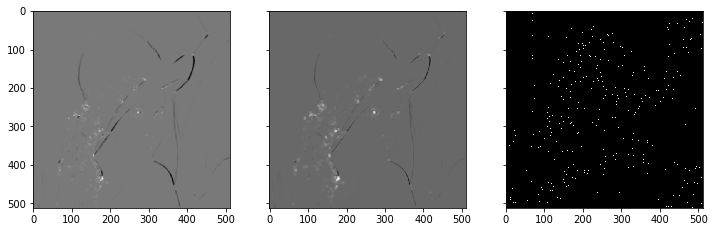

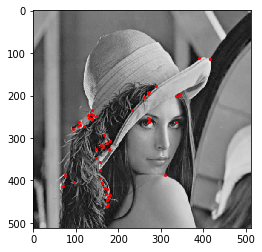

In [169]:
################################################ TODO ###############################################
file_name='lena.jpg'
input_image = cv2.imread(file_name,0).astype(float) # input image
l,m = input_image.shape # image shape

img = cv2.normalize(input_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
################################################ TODO ###############################################
# Generating the gaussian filter
sigma = 1
size = 4*sigma + 1
gauss_filt, gauss_filt_dx, gauss_filt_dy = gauss(size, sigma) # function call to gauss
    
################################################ TODO ###############################################
#Convolving the filter with the image
Ix = convolveim(img, gauss_filt_dx) # convolve image with dx filter
Iy = convolveim(img, gauss_filt_dy) # convolve image with dy filter

x,y = harris(Ix, Iy ,50)
################################################ TODO ###############################################
# plot the image with harris points
# Hint: you may use "plt.plot(x,y, 'ro')"
plt.plot(y,x, 'ro', markersize=2)
plt.imshow(img, cmap='gray')
plt.show()

## PART B - SIFT descriptor

Write a program that can generate SIFT descriptor for each detected feature point using your program in Prob. 1. You may follow the following steps:
- Generate gradient images Ix and Iy as before. Furthermore, determine the gradient magnitude and orientation from Ix and Iy at every pixel.
-  Quantize the orientation of each pixel to one of the N=8 bins. Suppose your original orientation is x. To quantize the entire range of 360 degree to 8 bins, the bin size is q=360/N=45 degree. Assuming your orientation is determined with a range of [0,360]. You can perform quantization using
 - (a) x_q=floor((x+q/2)/q);ifx_q=N,x_q=0
 - (b) x_q will range from 0 to 7,with 0 corresponding to degree in(-22.5,22.5), or (0, 22.5) and (360-22.5, 360).
 - (c) Then for each detected feature point, you may follow the following steps to generate the SIFT descriptor:
    - i) Generate a patch of size 16x16 centered at the detected feature point;
    - ii) Multiply the gradient magnitude with a Guassian window with scale= patch width/2. 
    - iii) Generate a HoG for the entire patch using the weighted gradient magnitude.
    - iv) Determine the dominant orientation of the patch by detecting the peak in the Hog determined in (e).
    - v) Generate a HoG for each of the 4x4 cell in the 16x16 patch.
    - vi) Shift each HoG so that the dominant orientation becomes the first bin. 
    - vii) Concatenate the HoG for all 16 cells into a single vector.
    - viii) Normalize the vector. That is, divide each entry by L2 norm of the vector. 
    - ix) Clip the normalized vector so that entries >0.2 is set to 0.2.
    - x) Renormalize the vector resulting from (k).

In [180]:
def histo(theta4,mag4):

    temp = np.zeros((1,8),dtype='float32')
    ################################################ TODO ###############################################
    # write code segment to add the magnitudes of all vectors in same orientations
    for i in np.arange(8):
        temp[0][i] = np.sum (mag4[np.where(theta4==i)])
    
    # temp should be a 1x8 vector, where each value corresponds to an orientation and 
    # contains the sum of all gradient magnitude, oriented in that orientation
    return temp

def descriptor(theta16,mag16):
    filt,_,_ = gauss(16,8) 
    mag16_filt = np.multiply(mag16, filt) 

    desp = np.array([])
    ################################################ TODO ###############################################
    histo16 = histo(theta16, mag16_filt) # make function call to histo, with arguments theta16 and mag16_fil
    maxloc_theta16 = np.argmax(histo16)

    for i in range(0,16,4):
        for j in range(0,16,4):
            ################################################ TODO ###############################################
            # use histo function to create histogram of oriantations on 4x4 pathces in the neighbourhood of the harris points
            # you should shift your histogram for each cell so that the dominant orientation of the 16x16 patch becomes the first quantized orientation
            # shifting can be done using np.roll( )
            # you should update the variable desp to store all the orientation magnitude sum for each sub region of size 4x4
            theta4 = theta16[i:i+4,j:j+4]
            mag4 = mag16_filt[i:i+4,j:j+4]
            
            histo4 = histo(theta4, mag4)
            histo4 = np.roll(histo4, maxloc_theta16)
            
            desp = np.append(desp, histo4)
    ################################################ TODO ###############################################
    # clip the descriptors after normalization

    desp = desp / np.linalg.norm(desp, 2)
    desp = np.matrix(desp)

    return desp

In [185]:
def part_B(input_image):
    p, q = input_image.shape # shape of input image

    # normalize the image
    img = cv2.normalize(input_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Generate derivative of Gaussian filters, using sigma=1, filter window size=4*sigma+1
    _, filt_x, filt_y = gauss(5, 1)

    ################################################ TODO ###############################################
    img_x = convolveim(img, filt_x) # image convolved with filt_x
    img_y = convolveim(img, filt_y) # image convolved with filt_y

    mag = np.sqrt(img_x ** 2 + img_y ** 2)
    theta = np.arctan2(img_x, img_y) + np.pi
    
    eplison = 1e-6
        
    for x in range(0, p):
        for y in range(0, q):
            temp = theta[x, y]
            if (temp < np.pi / 8 and temp >= 0) or (temp <= 2 * np.pi + eplison and temp >= (2 * np.pi - np.pi / 8)):
                theta[x, y] = 0
            elif (temp < 3*np.pi/8 and temp >= np.pi/8):
                theta[x, y] = 1
            elif (temp < 5*np.pi/8 and temp >= 3*np.pi/8):
                theta[x, y] = 2
            elif (temp < 7*np.pi/8 and temp >= 5*np.pi/8):
                theta[x, y] = 3
            elif (temp < 9*np.pi/8 and temp >= 7*np.pi/8):
                theta[x, y] = 4
            elif (temp < 11*np.pi/8 and temp >= 9*np.pi/8):
                theta[x, y] = 5
            elif (temp < 13*np.pi/8 and temp >= 11*np.pi/8):
                theta[x, y] = 6
            elif (temp < 15*np.pi/8 and temp >= 13*np.pi/8):
                theta[x, y] = 7
            else:
                print('what the fuck? theta = {}, something is seriously wrong'.format(temp))
                pass
            
            ################################################ TODO ###############################################
            # fill in the if condition for all other angles
    
    
    ################################################ TODO ###############################################
    x,y = harris(img_x, img_y ,50) # call harris function to find 50 feature points 
    
    # Adding 15 rows and columns. You will need this extra border to get a patch centered at the feature point 
    #    when the feature points lie on the original border of the image.
    theta = cv2.copyMakeBorder(theta, 7,8,7,8, cv2.BORDER_REFLECT, 0) # check the function definition for cv2.copyMakeBorder
    ################################################ TODO ###############################################
    mag = cv2.copyMakeBorder(mag, 7,8,7,8, cv2.BORDER_REFLECT, 0) # similarly add border to the magnitude image
    final_descriptor = np.zeros((1,128))
    final_points = np.transpose(np.matrix([x,y]))
    
    for i in range(0,len(x)):
        # Since you have already added 15 rows and columns, now the new coordinates of the feature points are (x+8, y+8).
        # Then the patch should be [x[i]:x[i]+16,y[i]:y[i]+16]
        theta_temp = theta[x[i]:x[i]+16,y[i]:y[i]+16] # Your patch should be centered at the feature point!
        mag_temp = mag[x[i]:x[i]+16,y[i]:y[i]+16] # similarly, take a 16x16 patch of mag around the point
        temp2 = descriptor(theta_temp, mag_temp) # function call to descriptors
        final_descriptor = np.append(final_descriptor,temp2,axis=0)

    # Initially, final descriptor has a row of zeros. We are deleting that extra row here.
    final_descriptor = np.delete(final_descriptor,0,0)
    final_descriptor = np.nan_to_num(final_descriptor)
    final_descriptor = np.array(final_descriptor)
    
    return final_descriptor,final_points

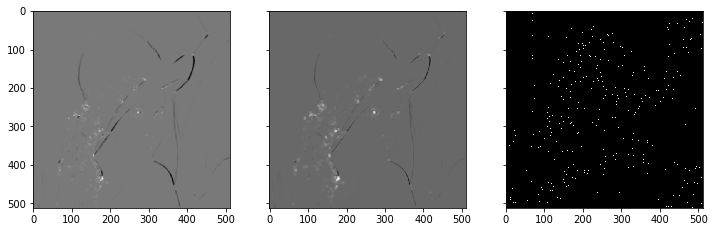

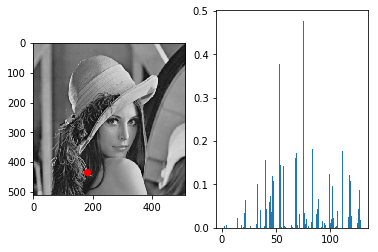

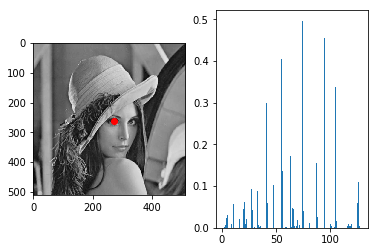

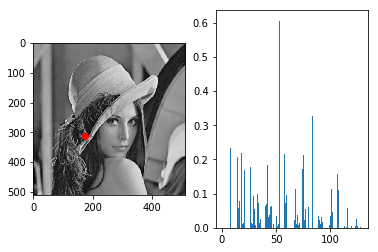

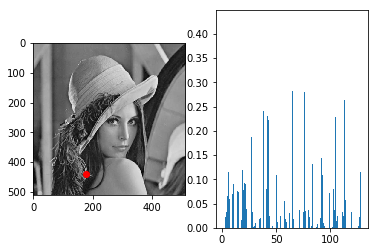

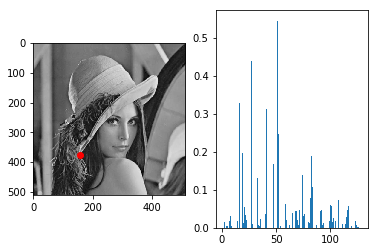

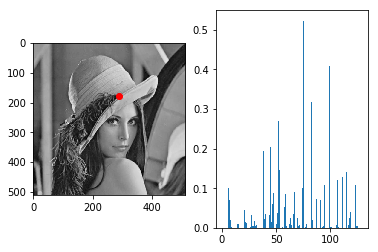

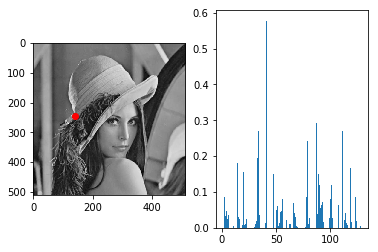

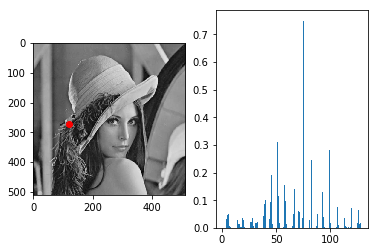

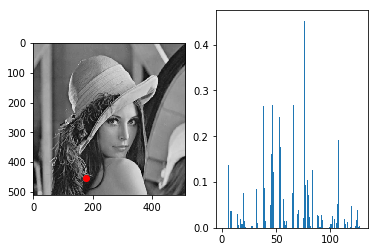

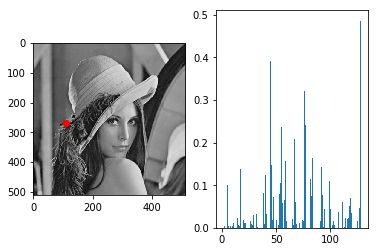

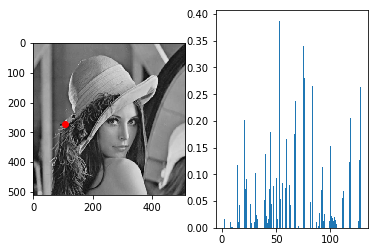

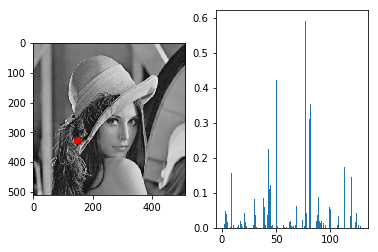

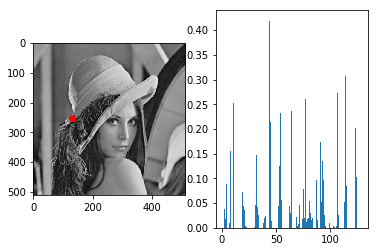

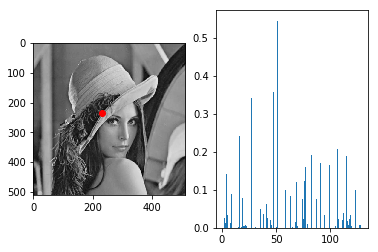

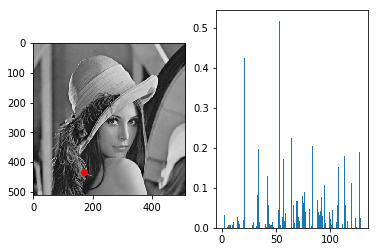

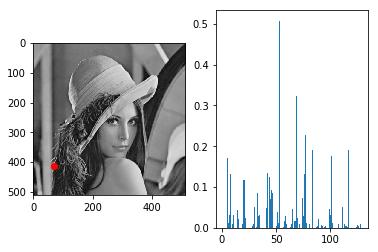

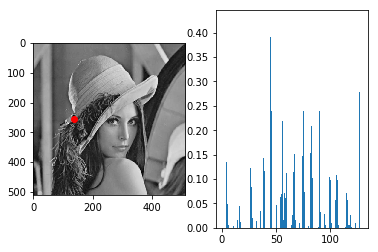

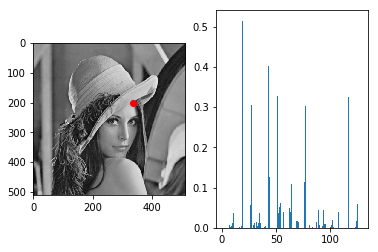

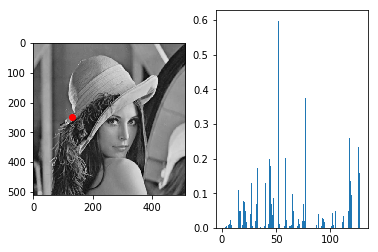

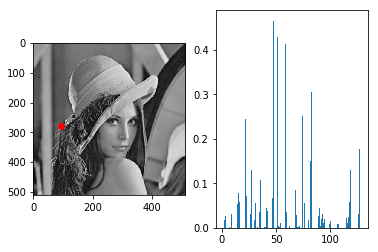

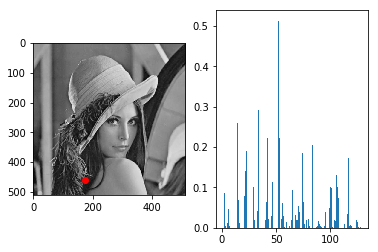

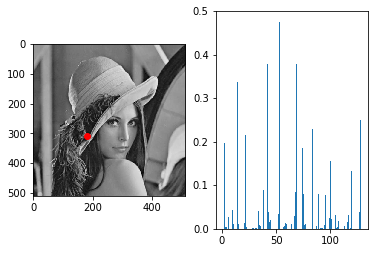

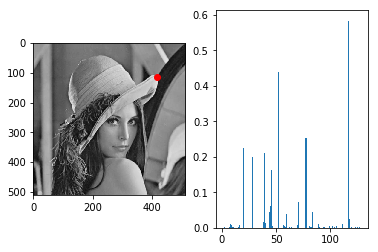

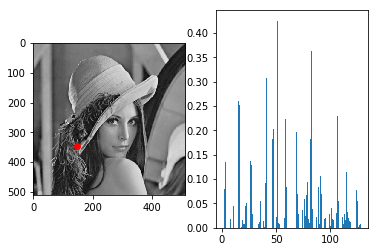

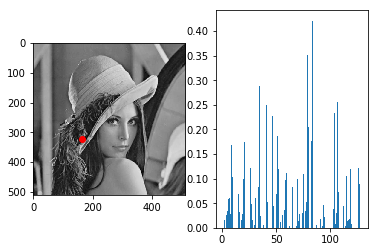

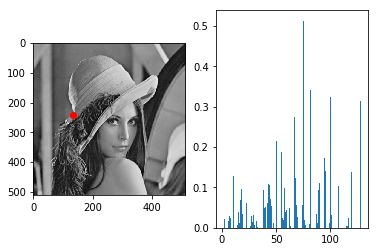

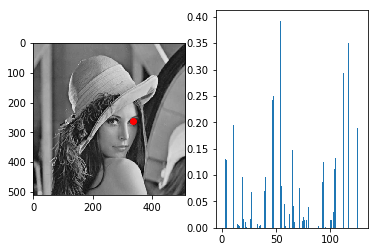

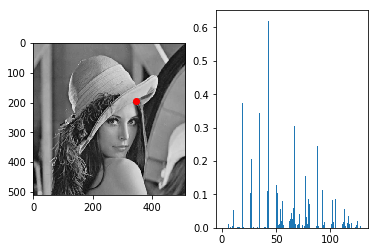

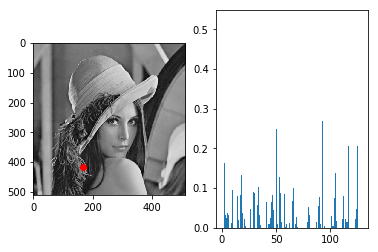

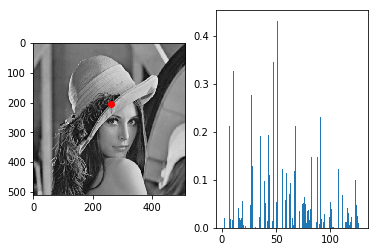

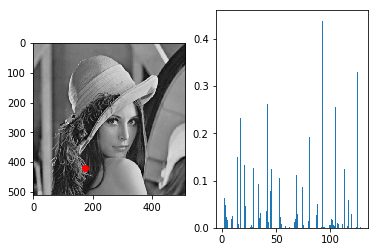

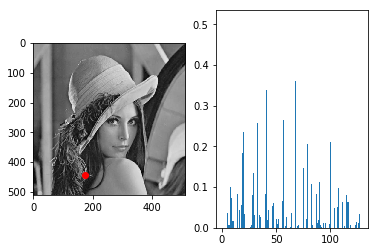

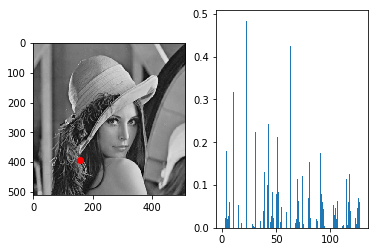

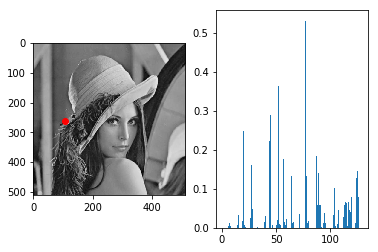

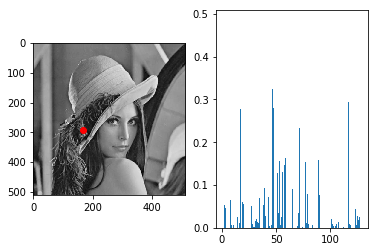

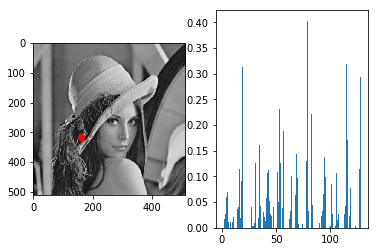

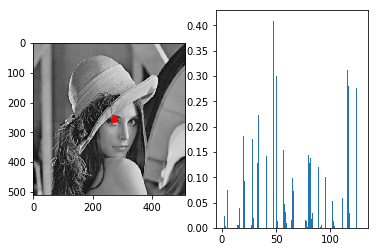

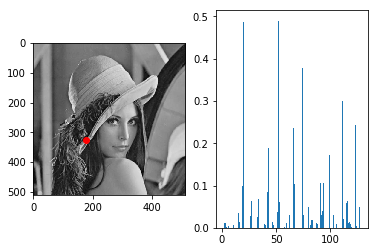

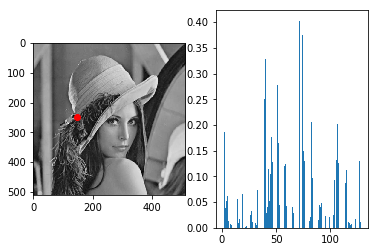

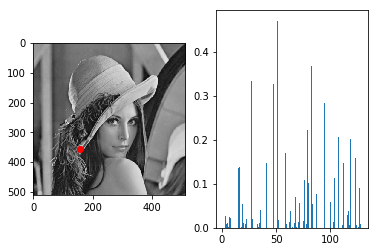

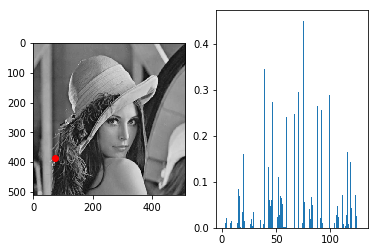

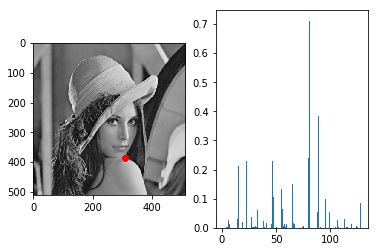

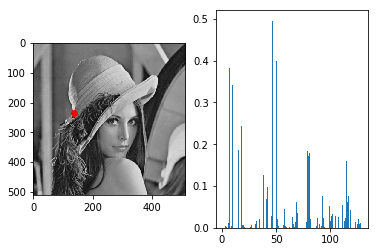

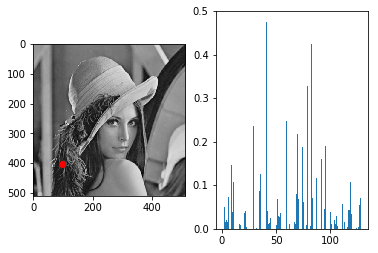

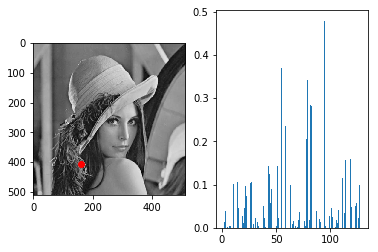

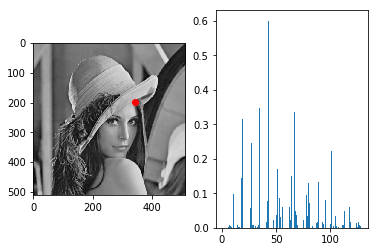

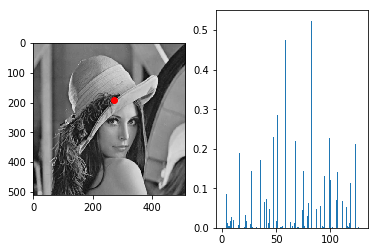

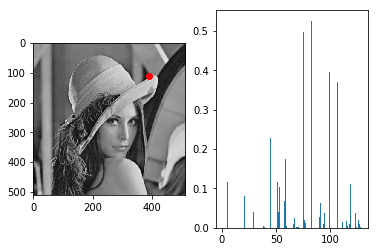

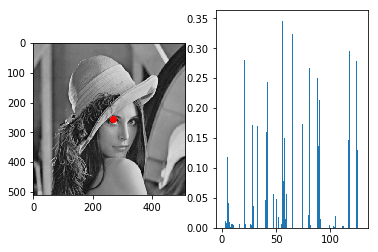

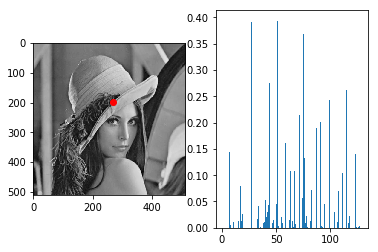

In [186]:
################################################ TODO ###############################################
file_name='lena.jpg'
input_image = cv2.imread(file_name,0).astype(float) # input image

final_descriptor , final_points = part_B(input_image)

for i in range(len(x)):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(input_image,cmap='gray')
    ax1.autoscale(False)
    ax1.plot(y[i], x[i], 'ro')
    ax2.bar(np.arange(1,129),final_descriptor[i,:])
    plt.show()

## PART C - correspondance in 2 images

Finding corresponding points in two images based on SIFT descriptors.
-  Using your program in Part A and Part B to detect feature points and generate their descriptors for two images provided with this assignment.(image named **left** and **right**)
-  Write a program that can find matching points between the two images. For each point p in the first image, you compute its distance to each point in the second image (using Euclidean distance between two SIFT descriptors) to find two closest points q1 and q2 in the second image. Let us call the distance of p to q1 and q2 by d1 and d2, you will take point q1 as the matching point for p if d1/d2 <r. Otherwise, you assume there is ambiguity between q1 and q2 and skip the feature point p in image 1. You can experiment with different threshold r. Obviously r should be <1. At the end of this process, you should have a set of matching pairs.
-  Create an image that shows the matching results. For example you can create a large image that has the left and right images side by side, and draw lines between matching pairs in these two images. Do the matched points look reasonable? You can use **cv2.line()** to draw line between each matching pair. You need to save and display the image after you add lines into the image array using the cv2.line() function.

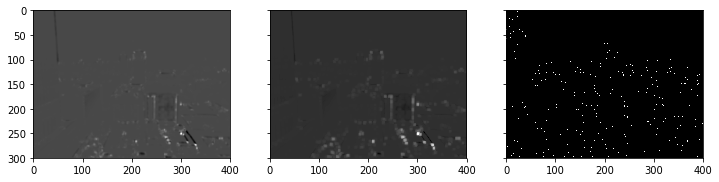

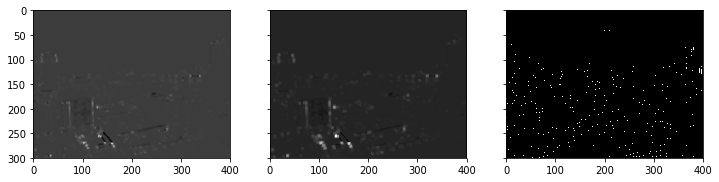

number of corresponding poitnts found: 18


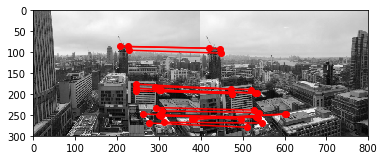

In [231]:
################################################ TODO ###############################################
img1 = cv2.imread('left.JPG',0).astype(float) # input image # read left image
img_1 = cv2.normalize(img1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
l,m = np.shape(img_1)

descriptor_1, keypoints_1 = part_B(img_1)

################################################ TODO ###############################################
# Generate a rotated image
# plot the rotated image with harris points.

img2 = cv2.imread('right.JPG',0).astype(float) # input image # read right image
img_2 = cv2.normalize(img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

descriptor_2, keypoints_2 = part_B(img_2)

matched_loca = list() # list of all corresponding points pairs. Point pairs can be stored as tuples

################################################ TODO ###############################################
# write code segment to find corresponding points in image

for pimg1_index, pimg1 in enumerate(keypoints_1):
    dist = np.sum((descriptor_1[pimg1_index][None,:] - descriptor_2)**2, axis=1)
    dist_index = np.argsort(dist)
    dist1, dist2 = dist[dist_index[0:2]]
    if (dist1/dist2) < 0.4:
        matched_loca.append((pimg1_index, dist_index[0]))
    
final_image = np.concatenate((img_1,img_2),axis=1)
print('number of corresponding poitnts found:',len(matched_loca))
################################################ TODO ###############################################
# write code segment to draw lines joining corresponding points
plt.figure()
plt.imshow(final_image,cmap='gray')
for pair in matched_loca:
    pt1 = np.array (keypoints_1 [pair[0]]).flatten()
    pt2 = np.array (keypoints_2 [pair[1]]).flatten()
    plt.plot([pt1[1], pt2[1] + m], [pt1[0], pt2[0]], 'ro-')
plt.show()

## PART D - panorama stiching

Stitch two images into a panorama using SIFT feature detector and descriptor.
- Read in an image pair (left and right)
- Detect SIFT points and extract SIFT features from each image by using the following OpenCV sample code. 



    - sift = cv2.xfeatures2d.SIFT_create()
    - skp = sift.detect(img,None)
    - (skp, features) = sift.compute(img, skp)



[comment]: ![](q_img.png)
 - **Where skp is a list of all the key points found from img and sd is the descriptor for the image. Each element in skp is an OpenCV ‘key points class’ object, and you can check the corresponding coordinate by skp[element_index].pt **
- Mark the detected points in each image by a circle with radius equal to the scale of the feature. You can check the scale of a detected point using skp[element_index].size
- Find the corresponding point pairs between left and right images based on their SIFT descriptors. You can reuse your program for Part-C.
- Apply RANSAC method to these matching pairs to find the largest subset of matching pairs that are related by the same homography. You can use the function cv2.findHomography(srcPoints, dstPoints, cv2.RANSAC)
- Create an image that shows the matching results by drawing lines between corresponding points. You can reuse the plotting function you developed for Part-C.
- Apply the homography determined in (e) to the right image. You can use cv2.warpPerspective() to apply the homography transformation to the image.
- Stitch the transformed image from (g) and the right image together to generate the panorama.

_Hint: you should first create am array for the stitched image whose width is larger of the width of transformed left image and the right image. Similarly, the height is the larger of the heights of the transformed left image and the right image. Then, you put transformed left image into this array, and then the original right image into this array. With this simple approach, the part where the two images overlap will be represented by the right image._

**In your report, show the left and right images, the left and right images with SIFT points indicated, the image that illustrates the matching line between corresponding points, the transformed left image, and finally the stitched image.**

**Also compare and talk about the correspondance found in the left and right image, using the harris features in part C and the SIFT descriptors in part D**

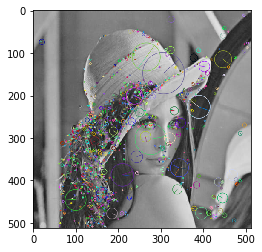

In [7]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
    # return the visualization
    return vis


################################################ TODO ###############################################
file_name='lena.jpg'
img = cv2.imread(file_name, 1) # read the test image in part A

gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()

################################################ TODO ###############################################
# use sift.detect to detect features in the images
kp = sift.detect(gray, None)

img_kps = cv2.drawKeypoints(gray,kp,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

################################################ TODO ###############################################
# plot the image with feature points marked out
# Compare it with result in part A
plt.imshow(img_kps)
plt.show()

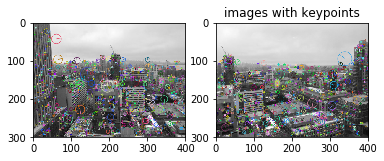

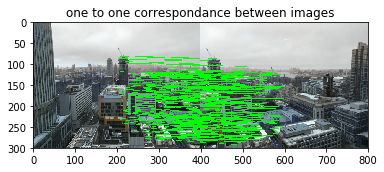

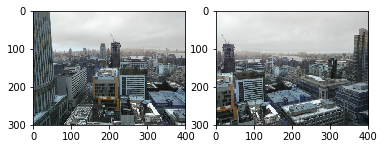

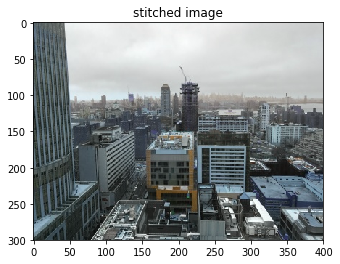

In [21]:
################################################ TODO ###############################################
img1 = cv2.imread('left.JPG', 1) # read left image
img2 = cv2.imread('right.JPG', 1) # read right iamge

gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

################################################ TODO ###############################################
# use sift.detect to detect features in the images
kp1 = sift.detect(gray1, None)
kp2 = sift.detect(gray2, None)

img1_kps = cv2.drawKeypoints(gray1,kp1,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kps = cv2.drawKeypoints(gray2,kp2,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

################################################ TODO ###############################################
# use sift.compute to generate sift descriptors
(kp1, features1) = sift.compute(gray1, kp1)
(kp2, features2) = sift.compute(gray2, kp2)


kp1 = np.float32([kp.pt for kp in kp1])
kp2 = np.float32([kp.pt for kp in kp2])

matcher = cv2.DescriptorMatcher_create("BruteForce")
################################################ TODO ###############################################
# use knnMatch function in matcher to find corresonding features
rawMatches = matcher.knnMatch(features1,features2, k=2)
matches = []

for m in rawMatches:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe's ratio test)
    ################################################ TODO ###############################################
    if len(m) == 2 and m[0].distance/m[1].distance < 0.5: # complete the if statement.test the distance between points. use m[0].distance and m[1].distance
        matches.append((m[0].trainIdx, m[0].queryIdx))

ptsA = np.float32([kp1[i] for (_,i) in matches])
ptsB = np.float32([kp2[i] for (i,_) in matches])

################################################ TODO ###############################################
(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,5.0) # fill in the parameters 
result = cv2.warpPerspective(img2, H, (img2.shape[1], img2.shape[0]))# fill in the arguments to warp the second image to fit the first image.
result[0:img2.shape[0], 0:img2.shape[1]] = img1

vis = drawMatches(img1,img2,kp1,kp2,matches,status)

plt.figure()
plt.subplot(121)
plt.imshow(img1_kps)
plt.subplot(122)
plt.imshow(img2_kps)
plt.title('images with keypoints')
plt.show()

plt.figure()
plt.imshow(vis)
plt.title('one to one correspondance between images')
plt.show()

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plt.imshow(result)
plt.title('stitched image')
plt.show()